# Imports

In [1]:
# Standard library imports
import joblib

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, randint, uniform, reciprocal, expon

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt

# Scikit-learn imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, 
                                     GridSearchCV, cross_val_score, RandomizedSearchCV)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder, MinMaxScaler, 
                                   Normalizer, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, 
                                   PowerTransformer, QuantileTransformer, StandardScaler)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# XGBoost import
from xgboost import XGBClassifier

# Reading the data

In [2]:
train_data = pd.read_csv('C:\\Users\\fabio\\Downloads\\Final Spaceship\\Final Spaceship\\Final Spaceship\\train.csv')
test_data = pd.read_csv('C:\\Users\\fabio\\Downloads\\Final Spaceship\\Final Spaceship\\Final Spaceship\\test.csv')

# Data processing

### Tweaking

In [3]:
# The name of the passengers isn't going to be used for nothing in this notebook
test_data.drop('Name',inplace=True,axis=1)
train_data.drop('Name', axis=1, inplace=True)

# The passenger group was utilized in processing steps so I already added it here to the DataFrame
test_data['passenger_group']=test_data['PassengerId'].apply(lambda x: x[0:4])
train_data['passenger_group']=train_data['PassengerId'].apply(lambda x: x[0:4])

# The passenger IDs will be used at the end to return the correct IDs with the model previsions
test_passenger_id = test_data['PassengerId']
passenger_id = train_data['PassengerId']

In [4]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passenger_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280


### Classes and functions

In [5]:
binary_columns = ['CryoSleep','VIP']
numeric_columns = ['FoodCourt','RoomService','Spa','VRDeck','ShoppingMall']

cabin_ix = 3 # The cabin index is used in the CabinSeparator class

class CabinSeparator(BaseEstimator, TransformerMixin):
    
    # The Cabin info has the aggregated information of the cabin deck, side and number. This function stores all the information but just returns to the original
    # dataframe the cabin deck and side, given that the number can go until past 1000 and would probably overfit the data and not help very much
    def __init__(self, add_separate_cabin=True):
        self.add_separate_cabin = add_separate_cabin
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_separate_cabin:
            X = pd.DataFrame(X)
            cabin_deck = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0])
            cabin_num = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0] if len(str(s).split('/'))==1 else str(s).split('/')[1])
            cabin_side = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0] if len(str(s).split('/'))==1 else str(s).split('/')[2])
            X['cabin_deck'] = cabin_deck
            X['cabin_side'] = cabin_side
            X = X.drop(X.columns[[cabin_ix]], axis=1)
            return X.values 
        else:
            return X
    def get_feature_names_out(self):
        return ['cabin_deck','cabin_num','cabin_side']
    
    
class FillBinaryNumericTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # I am assuming here that if there is no record of the person in CryoSleep or if they are on the VIP list they probably aren't in neither
        X.loc[:, binary_columns] = X[binary_columns].fillna(False)
        # The same logic applies here, if there is no record of the passenger spending money, they probably didn't spend it
        X.loc[:, numeric_columns] = X[numeric_columns].fillna(0)
        return X

class FillCabinDestHomeAgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Here the function groups the data by the passanger group, and fills in the other data based on the info of another passanger that's in their group
        # For example if the daughter didn't put her data correct but her mother did, the code will retrieve that information
        X['Cabin'] = X.groupby('passenger_group')['Cabin'].transform(lambda x: x.fillna(x.iloc[0]))
        X['Destination'] = X.groupby('passenger_group')['Destination'].transform(lambda x: x.fillna(x.iloc[0]))
        X['HomePlanet'] = X.groupby('passenger_group')['HomePlanet'].transform(lambda x: x.fillna(x.iloc[0]))
        X['Age'] = X.groupby('passenger_group')['Age'].transform(lambda value: value.fillna(value.mean()))
        return X

class FillRestTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # For the groups that didn't have any information, I just decided to fill in the Age with the mean of values from that group and the other just a 'None' string
        X['Age'] = X.groupby('passenger_group')['Age'].transform(lambda value: value.fillna(value.mean()))
        X['Age'] = X['Age'].transform(lambda value: value.fillna(value.mean()))
        X[['Cabin','HomePlanet','Destination']] = X[['Cabin','HomePlanet','Destination']].fillna('None')
        return X

class AddTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        total_spent = np.sum(X[:, 5:10], axis=1)
        X = np.column_stack((X, total_spent))
        return X
    
class AddPolyFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3, addpoly=True):
        self.degree = degree
        self.addpoly = addpoly
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
    
    def fit(self, X, y=None):
        if self.addpoly:
            self.poly.fit(X)
        return self
    
    def transform(self, X):
        if self.addpoly:
            return self.poly.transform(X)
        else:
            return X
        
class AddInverse(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['1/Age'] = 1/X['Age']
        X['1/RoomService'] = 1/X['RoomService']
        X['1/FoodCourt'] = 1/X['FoodCourt']
        X['1/ShoppingMall'] = 1/X['ShoppingMall']
        X['1/Spa'] = 1/X['Spa']
        X['1/VRDeck'] = 1/X['VRDeck']
        return X

In [6]:
train_column_names = [col for col in train_data.columns if col != 'Cabin'] + ['cabin_deck','cabin_side','total_spent']
test_column_names = [col for col in test_data.columns if col != 'Cabin'] + ['cabin_deck','cabin_side','total_spent']

preprocessing = Pipeline([
    ('binary_numeric', FillBinaryNumericTransformer()),
    ('cabin_dest_home_age', FillCabinDestHomeAgeTransformer()),
    ('rest', FillRestTransformer()),
    ('cabin_separator', CabinSeparator()),
    ('add_total_spent', AddTotalSpent()),
])

treated_train_data = pd.DataFrame(preprocessing.fit_transform(train_data), columns=train_column_names)
treated_test_data = pd.DataFrame(preprocessing.transform(test_data), columns=test_column_names)

columns_to_convert = ['total_spent', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Convert columns to numeric type
treated_train_data[columns_to_convert] = treated_train_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
treated_test_data[columns_to_convert] = treated_test_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

treated_train_data[['VIP','CryoSleep']] = treated_train_data[['VIP','CryoSleep']].astype(int)
treated_test_data[['VIP','CryoSleep']] = treated_test_data[['VIP','CryoSleep']].astype(int)

C:\Users\fabio\AppData\Local\Temp\ipykernel_6956\3289218970.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, binary_columns] = X[binary_columns].fillna(False)
C:\Users\fabio\AppData\Local\Temp\ipykernel_6956\3289218970.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, binary_columns] = X[binary_columns].fillna(False)


In [7]:
treated_train_data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passenger_group,cabin_deck,cabin_side,total_spent
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0001,B,P,0.0
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,True,0002,F,S,692.0
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,S,10335.0
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,S,4983.0
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,True,0004,F,S,1089.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,False,9276,A,P,8463.0
8689,9278_01,Earth,1,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,False,9278,G,S,0.0
8690,9279_01,Earth,0,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,True,9279,G,S,1873.0
8691,9280_01,Europa,0,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,False,9280,E,S,1402.0


# EDA

In [8]:
numeric_cols = treated_train_data[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','total_spent']]
numeric_cols.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,692.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10335.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,4983.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1089.0


## PCA

In [9]:
labels = treated_train_data.Transported

In [10]:
pca_transformer = PCA(n_components=0.865)
pca_numeric = pca_transformer.fit_transform(numeric_cols)
pca_data = pd.DataFrame(pca_numeric, columns=['pca_1','pca_2','pca_3'])
pca_data

,pca_1,pca_2,pca_3
0,-1290.173523,-114.643661,-167.120888
1,-566.708663,389.212252,-49.012739
2,10668.873369,4133.058411,10.955268
3,4315.921152,2267.499282,186.680838
4,-194.558380,497.109909,-136.177138
...,...,...,...
8688,9453.887933,-1677.606392,-1737.876893
8689,-1290.192371,-114.647978,-167.137489
8690,336.015703,489.224286,-338.654976
8691,828.335909,-1191.353244,2650.633158


In [11]:
scaler = StandardScaler()
pca_standardized = pd.DataFrame(scaler.fit_transform(pca_data))

yeo_johnson_scaler = PowerTransformer(method='yeo-johnson')
pca_yeo_johnson = yeo_johnson_scaler.fit_transform(pca_standardized)

quantile_scaler = QuantileTransformer(output_distribution='normal')
pca_quantile_normalized = quantile_scaler.fit_transform(pca_standardized)

zero_or_negative_indices = pca_standardized <= 0
pca_standardized_fixed = np.where(zero_or_negative_indices, 1e-9, pca_standardized)
pca_log_transformed = pd.DataFrame(np.log1p(pca_standardized_fixed))

<Axes: xlabel='1', ylabel='Count'>

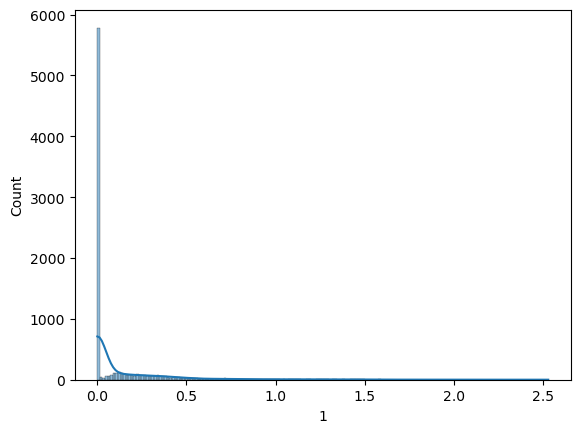

In [12]:
sns.histplot(pca_log_transformed[1], kde=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


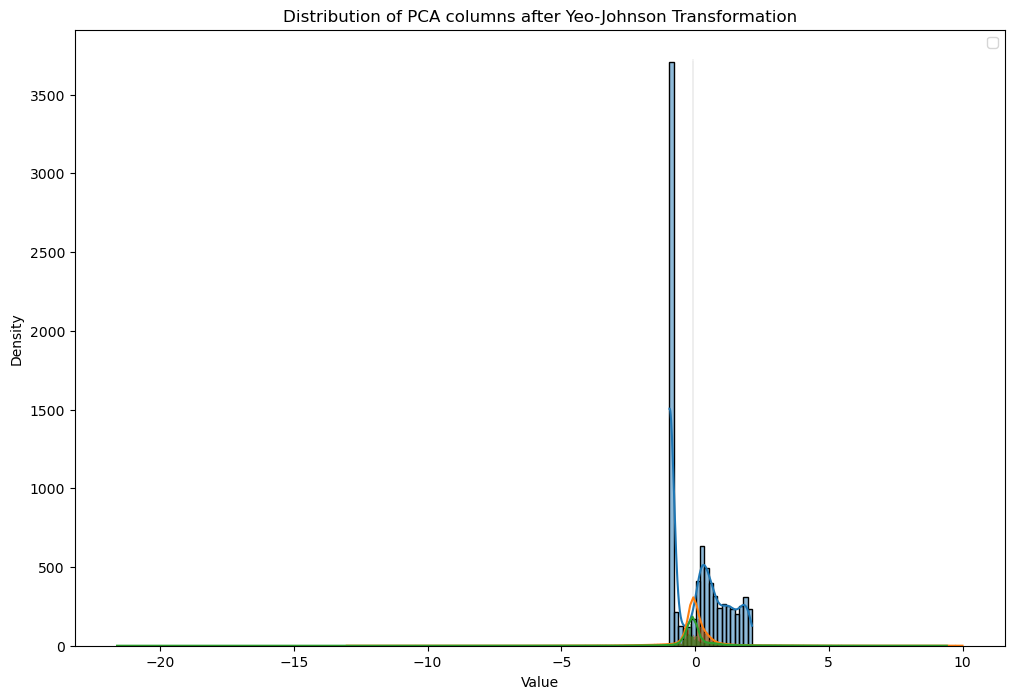

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


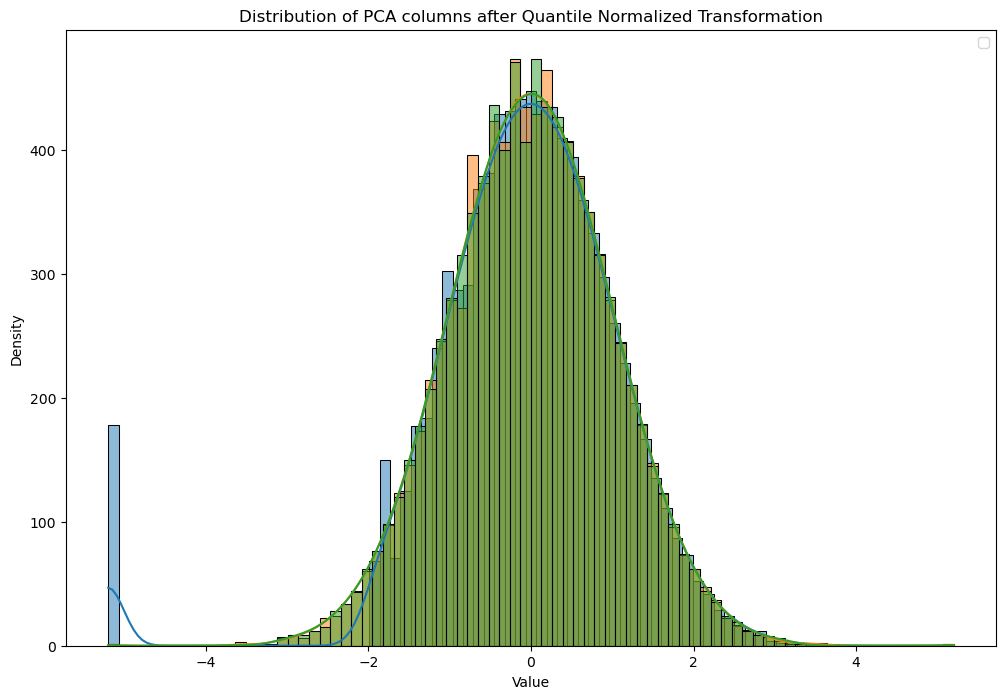

In [13]:
transformations = {
    'Yeo-Johnson': pca_yeo_johnson,
    'Quantile Normalized': pca_quantile_normalized,
}

# Define the columns to plot
columns_to_plot = ['pca_1', 'pca_2', 'pca_3']

# Plot the distributions
for method, transformed_data in transformations.items():
    plt.figure(figsize=(12, 8))
    for column in columns_to_plot:
        index = columns_to_plot.index(column)
        sns.histplot(transformed_data[:, index], kde=True)
    plt.title(f'Distribution of PCA columns after {method} Transformation')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

<Axes: ylabel='Count'>

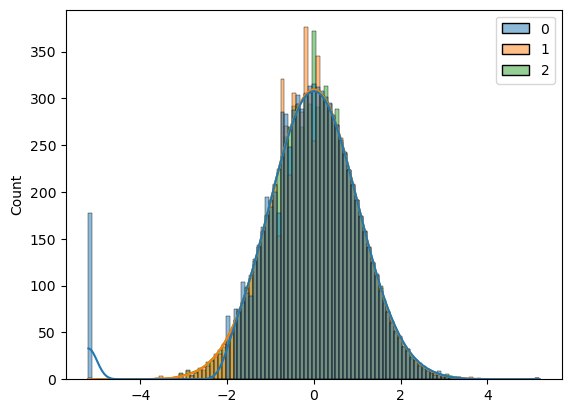

In [14]:
sns.histplot(pca_quantile_normalized, kde=True)

### 3D view

In [15]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the points with appropriate markers for True/False
for i in range(100):
    marker = 'o' if labels[i] else '^'  # Use 'o' for True and '^' for False
    color = 'g' if labels[i] else 'r'   # Use green for True and red for False
    ax.scatter(pca_numeric[i, 0], pca_numeric[i, 1], pca_numeric[i, 2], 
               marker=marker, color=color, s=64)

# Setting axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a legend
true_marker = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='True')
false_marker = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='r', markersize=10, label='False')
ax.legend(handles=[true_marker, false_marker])

plt.show()

<IPython.core.display.Javascript object>

### Concatenating DataFrames

In [16]:
cat_columns = treated_train_data.drop(['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','total_spent'], axis=1)
cat_pca_data = pd.concat([cat_columns, pca_data], axis=1)
cat_pca_data

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Transported,passenger_group,cabin_deck,cabin_side,pca_1,pca_2,pca_3
0,0001_01,Europa,0,TRAPPIST-1e,0,False,0001,B,P,-1290.173523,-114.643661,-167.120888
1,0002_01,Earth,0,TRAPPIST-1e,0,True,0002,F,S,-566.708663,389.212252,-49.012739
2,0003_01,Europa,0,TRAPPIST-1e,1,False,0003,A,S,10668.873369,4133.058411,10.955268
3,0003_02,Europa,0,TRAPPIST-1e,0,False,0003,A,S,4315.921152,2267.499282,186.680838
4,0004_01,Earth,0,TRAPPIST-1e,0,True,0004,F,S,-194.558380,497.109909,-136.177138
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,55 Cancri e,1,False,9276,A,P,9453.887933,-1677.606392,-1737.876893
8689,9278_01,Earth,1,PSO J318.5-22,0,False,9278,G,S,-1290.192371,-114.647978,-167.137489
8690,9279_01,Earth,0,TRAPPIST-1e,0,True,9279,G,S,336.015703,489.224286,-338.654976
8691,9280_01,Europa,0,55 Cancri e,0,False,9280,E,S,828.335909,-1191.353244,2650.633158


## Inverse

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


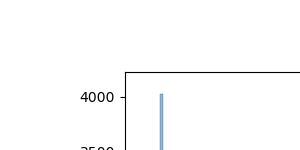

In [17]:
for column in numeric_cols.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(numeric_cols[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [18]:
numeric_cols['RoomService'] = numeric_cols['RoomService'].apply(lambda x: 0.0001 if x == 0 else x)
numeric_cols['FoodCourt'] = numeric_cols['FoodCourt'].apply(lambda x: 0.0001 if x == 0 else x)
numeric_cols['ShoppingMall'] = numeric_cols['ShoppingMall'].apply(lambda x: 0.0001 if x == 0 else x)
numeric_cols['Spa'] = numeric_cols['Spa'].apply(lambda x: 0.0001 if x == 0 else x)
numeric_cols['VRDeck'] = numeric_cols['VRDeck'].apply(lambda x: 0.0001 if x == 0 else x)

numeric_cols

C:\Users\fabio\AppData\Local\Temp\ipykernel_6956\1496484526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols['RoomService'] = numeric_cols['RoomService'].apply(lambda x: 0.0001 if x == 0 else x)
C:\Users\fabio\AppData\Local\Temp\ipykernel_6956\1496484526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols['FoodCourt'] = numeric_cols['FoodCourt'].apply(lambda x: 0.0001 if x == 0 else x)
C:\Users\fabio\AppData\Local\Temp\ipykernel_6956\1496484526.py:3: SettingWithCopyWarning: 
A v

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent
0,39.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0
1,24.0,109.0000,9.0000,25.0000,549.0000,44.0000,692.0
2,58.0,43.0000,3576.0000,0.0001,6715.0000,49.0000,10335.0
3,33.0,0.0001,1283.0000,371.0000,3329.0000,193.0000,4983.0
4,16.0,303.0000,70.0000,151.0000,565.0000,2.0000,1089.0
...,...,...,...,...,...,...,...
8688,41.0,0.0001,6819.0000,0.0001,1643.0000,74.0000,8463.0
8689,18.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0
8690,26.0,0.0001,0.0001,1872.0000,1.0000,0.0001,1873.0
8691,32.0,0.0001,1049.0000,0.0001,353.0000,3235.0000,1402.0


<IPython.core.display.Javascript object>


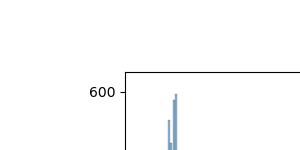

<IPython.core.display.Javascript object>


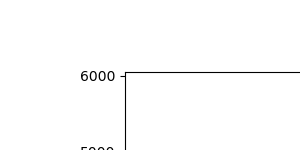

<IPython.core.display.Javascript object>


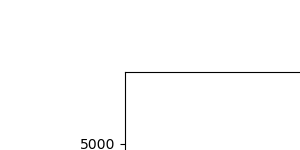

<IPython.core.display.Javascript object>


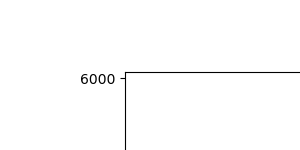

<IPython.core.display.Javascript object>


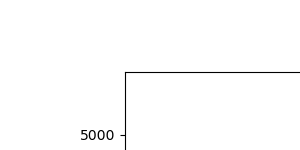

<IPython.core.display.Javascript object>


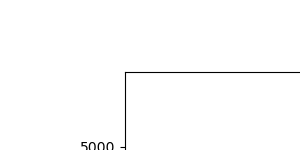

In [19]:
inverse_numeric_cols = pd.DataFrame()
inverse_numeric_cols['1/Age'] = 1/numeric_cols['Age']
inverse_numeric_cols['1/RoomService'] = 1/numeric_cols['RoomService']
inverse_numeric_cols['1/FoodCourt'] = 1/numeric_cols['FoodCourt']
inverse_numeric_cols['1/ShoppingMall'] = 1/numeric_cols['ShoppingMall']
inverse_numeric_cols['1/Spa'] = 1/numeric_cols['Spa']
inverse_numeric_cols['1/VRDeck'] = 1/numeric_cols['VRDeck']

for column in inverse_numeric_cols.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(inverse_numeric_cols[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

<IPython.core.display.Javascript object>


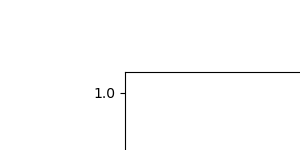

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


<IPython.core.display.Javascript object>


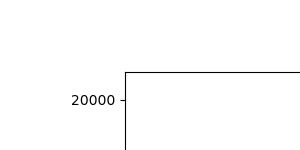

<IPython.core.display.Javascript object>


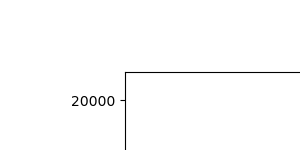

<IPython.core.display.Javascript object>


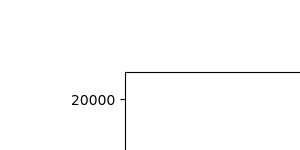

<IPython.core.display.Javascript object>


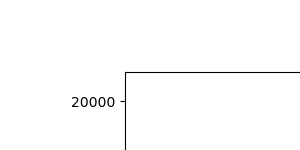

<IPython.core.display.Javascript object>


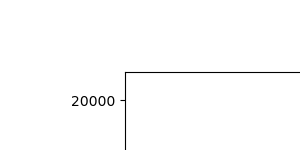

In [20]:
import scipy.stats as stats

for column in inverse_numeric_cols.columns:
    plt.figure(figsize=(10, 6))
    stats.probplot(inverse_numeric_cols[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
    plt.show()

In [21]:
inverse_numeric_cols

,1/Age,1/RoomService,1/FoodCourt,1/ShoppingMall,1/Spa,1/VRDeck
0,0.025641,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
1,0.041667,0.009174,0.111111,0.040000,0.001821,0.022727
2,0.017241,0.023256,0.000280,10000.000000,0.000149,0.020408
3,0.030303,10000.000000,0.000779,0.002695,0.000300,0.005181
4,0.062500,0.003300,0.014286,0.006623,0.001770,0.500000
...,...,...,...,...,...,...
8688,0.024390,10000.000000,0.000147,10000.000000,0.000609,0.013514
8689,0.055556,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
8690,0.038462,10000.000000,10000.000000,0.000534,1.000000,10000.000000
8691,0.031250,10000.000000,0.000953,10000.000000,0.002833,0.000309


In [22]:
from scipy.stats import skew, kurtosis

for column in inverse_numeric_cols.columns:
    skewness = skew(inverse_numeric_cols[column])
    kurt = kurtosis(inverse_numeric_cols[column])
    print(f'Skewness: {skewness}')
    print(f'Kurtosis: {kurt}')

Skewness: nan
Kurtosis: nan
Skewness: -0.686706244210773
Kurtosis: -1.5284345311261085
Skewness: -0.6229095442760614
Kurtosis: -1.6119836967484167
Skewness: -0.7069237720283469
Kurtosis: -1.500258776796437
Skewness: -0.5541083802746932
Kurtosis: -1.6929638994688136
Skewness: -0.6462891791051143
Kurtosis: -1.5823102936288027


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


In [23]:
skewness = skew(inverse_numeric_cols)

In [24]:
skewness

array([        nan, -0.68670624, -0.62290954, -0.70692377, -0.55410838,
       -0.64628918])

In [25]:
inverse_numeric_cols.describe()

,1/Age,1/RoomService,1/FoodCourt,1/ShoppingMall,1/Spa,1/VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,inf,6623.747000,6486.855125,6666.315422,6335.015111,6537.473780
std,NaN,4729.244219,4774.056689,4714.406389,4818.721447,4757.991174
min,0.012658,0.000070,0.000034,0.000043,0.000045,0.000041
25%,0.027027,0.024390,0.016393,0.045455,0.018868,0.025000
50%,0.037037,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
75%,0.052632,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
max,inf,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


# Model

In [26]:
treated_test_data.drop(['PassengerId','passenger_group'], axis=1, inplace=True)

In [27]:
y_train = treated_train_data['Transported']
treated_train_data.drop(['Transported','PassengerId','passenger_group'], inplace=True, axis=1)
X_train, X_val, y_train, y_val = train_test_split(treated_train_data, y_train, train_size = 0.8)

In [28]:
X_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_deck,cabin_side,total_spent
6218,Europa,0,TRAPPIST-1e,22.0,0,0.0,335.0,0.0,818.0,3014.0,A,P,1153.0
429,Earth,0,55 Cancri e,1.0,0,0.0,0.0,0.0,0.0,0.0,G,S,0.0
6295,Earth,0,TRAPPIST-1e,18.0,0,0.0,0.0,827.0,0.0,0.0,G,S,827.0
7944,Europa,1,TRAPPIST-1e,60.0,0,0.0,0.0,0.0,0.0,0.0,B,S,0.0
2947,Earth,0,PSO J318.5-22,11.0,0,0.0,0.0,0.0,0.0,0.0,G,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631,Europa,0,TRAPPIST-1e,25.0,0,0.0,0.0,0.0,0.0,0.0,D,P,0.0
7542,Earth,0,TRAPPIST-1e,20.0,0,0.0,25.0,0.0,11.0,0.0,F,S,36.0
839,Earth,0,TRAPPIST-1e,18.0,0,200.0,124.0,0.0,413.0,0.0,F,P,737.0
3844,Europa,0,TRAPPIST-1e,45.0,0,0.0,2524.0,0.0,166.0,1.0,B,P,2690.0


In [29]:
X_train['1/Age'] = 1/(X_train['Age']+0.001)
X_train['1/RoomService'] = 1/(X_train['Age']+0.001)
X_train['1/FoodCourt'] = 1/(X_train['Age']+0.001)
X_train['1/ShoppingMall'] = 1/(X_train['Age']+0.001)
X_train['1/Spa'] = 1/(X_train['Age']+0.001)
X_train['1/VRDeck'] = 1/(X_train['Age']+0.001)

X_train.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent,1/Age,1/RoomService,1/FoodCourt,1/ShoppingMall,1/Spa,1/VRDeck
count,6954.000000,6954.00000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000
mean,0.354760,28.76862,0.022721,223.534225,433.928818,172.119931,301.188525,292.119500,1130.794219,21.194027,21.194027,21.194027,21.194027,21.194027,21.194027
std,0.478475,14.44904,0.149022,674.497303,1539.158783,627.745494,1106.625006,1111.328597,2282.308336,143.849623,143.849623,143.849623,143.849623,143.849623,143.849623
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.012658,0.012658,0.012658,0.012658,0.012658
25%,0.000000,19.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027026,0.027026,0.027026,0.027026,0.027026,0.027026
50%,0.000000,27.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,392.500000,0.037036,0.037036,0.037036,0.037036,0.037036,0.037036
75%,1.000000,37.00000,0.000000,42.000000,50.000000,22.000000,52.000000,34.750000,1190.250000,0.052629,0.052629,0.052629,0.052629,0.052629,0.052629
max,1.000000,79.00000,1.000000,14327.000000,27723.000000,23492.000000,22408.000000,20336.000000,35970.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


### Create new features

### PCA Pipeline

In [30]:
# Define the preprocessing pipelines for numeric and categorical data
numeric_pipeline = Pipeline(steps=[
    ('pca', PCA(n_components=0.865)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Combine numeric and categorical pipelines using make_column_selector
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_pipeline, make_column_selector(dtype_include='object'))
    ]
)

# Define the final pipeline including the preprocessor and the quantile transformer
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('quantile', QuantileTransformer(output_distribution='normal'))
])

# Fit the pipeline to the training data
final_pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('pca',
                                                                   PCA(n_components=0.865)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001278D6A3710>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001278D7F8910>)])),
                ('quantile',
                 QuantileTransformer(output_distribution='normal'))])

### New Features Pipeline

In [31]:
other_feat = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spent']

other_feat_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('quantile', QuantileTransformer(output_distribution='normal'))
])

# Combine the preprocessing steps using ColumnTransformer
other_feat_preprocessor = ColumnTransformer(
    transformers=[
        ('scale_quantile', other_feat_pipeline, other_feat)
    ],
    remainder='passthrough'  # Keep the remaining columns unchanged
)

# Define the final pipeline
other_feat_final_pipeline = Pipeline(steps=[
    ('preprocessor', other_feat_preprocessor)
])

other_feat_final_pipeline.fit(X_train[other_feat])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_quantile',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('quantile',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'total_spent'])]))])

### Apply the pipelines

In [32]:
X_train_treated = pd.DataFrame(final_pipeline.transform(X_train), columns=final_pipeline.get_feature_names_out())

X_val_treated = pd.DataFrame(final_pipeline.transform(X_val), columns=final_pipeline.get_feature_names_out())

X_test_treated = pd.DataFrame(final_pipeline.transform(treated_test_data), columns=final_pipeline.get_feature_names_out())

other_X_train = pd.DataFrame(other_feat_final_pipeline.transform(X_train[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

other_X_val = pd.DataFrame(other_feat_final_pipeline.transform(X_val[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

other_X_test = pd.DataFrame(other_feat_final_pipeline.transform(treated_test_data[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

X_train = pd.concat([X_train_treated, other_X_train], axis=1)
X_val = pd.concat([X_val_treated, other_X_val], axis=1)
X_test = pd.concat([X_test_treated, other_X_test], axis=1)

ValueError: columns are missing: {'1/RoomService', '1/FoodCourt', '1/VRDeck', '1/Spa', '1/ShoppingMall', '1/Age'}

In [ ]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

### Train models

In [ ]:
xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(enable_categorical=True, n_jobs=-1)), # Classifier step
])

xgb_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_train, xgb_pipeline.predict(X_train))
cm

In [ ]:
accuracy_scores = cross_val_score(xgb_pipeline, X_val, y_val, cv=10)  # 5-fold cross-validation

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Compute the mean accuracy across all folds
mean_accuracy = accuracy_scores.mean()
print("Mean accuracy:", mean_accuracy)

In [ ]:
param_distribs_xgb = {
    'xgb__n_estimators': randint(100, 500), 
    'xgb__learning_rate': uniform(0.01, 0.3), 
    'xgb__subsample': uniform(0.5, 0.49), 
    'xgb__max_depth': randint(3, 15),
    'xgb__colsample_bytree': uniform(0.5, 0.49),  
    'xgb__min_child_weight': randint(1, 10),
}

rnd_search_xgb = RandomizedSearchCV(xgb_pipeline, param_distribs_xgb, n_iter=200, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [ ]:
rnd_search_xgb.fit(X_train, y_train)

In [ ]:
print(rnd_search_xgb.best_params_)

print(rnd_search_xgb.best_score_)

final_xgb = rnd_search_xgb.best_estimator_

In [ ]:
accuracy_scores = cross_val_score(final_xgb, X_val, y_val, cv=10)  # 5-fold cross-validation

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Compute the mean accuracy across all folds
mean_accuracy = accuracy_scores.mean()
print("Mean accuracy:", mean_accuracy)

In [ ]:
svc_pipeline = Pipeline([
    ('svc', SVC(), )  # Classifier step
])

svc_pipeline.fit(X_train, y_train)

In [ ]:
accuracy_scores = cross_val_score(svc_pipeline, X_train, y_train, cv=10)  # 5-fold cross-validation

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Compute the mean accuracy across all folds
mean_accuracy = accuracy_scores.mean()
print("Mean accuracy:", mean_accuracy)

In [ ]:
lr_pipeline = Pipeline([
    ('lr', LogisticRegression(max_iter=1000), )  # Classifier step
])

lr_pipeline.fit(X_train, y_train)

accuracy_scores = cross_val_score(lr_pipeline, X_val, y_val, cv=10)  # 5-fold cross-validation

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Compute the mean accuracy across all folds
mean_accuracy = accuracy_scores.mean()
print("Mean accuracy:", mean_accuracy)

In [ ]:
misclassified_indices = np.where(y_val != final_xgb.predict(X_val))[0]
misclassified_samples = treated_train_data.iloc[misclassified_indices]